<a href="https://colab.research.google.com/github/andreasnaoum/drought-damage-prediction/blob/main/Drought_Damage_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Pre-requests for ML Model

In [ ]:
!pip install tensorflow
!pip install pandas

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

# Load Data & Preprocessing

In [ ]:
def resize_with_padding(image_path, target_size):
    # Open the image
    img = Image.open(image_path)

    # Calculate the aspect ratio
    original_width, original_height = img.size
    aspect_ratio = original_width / original_height

    # Determine the new size while maintaining aspect ratio
    if aspect_ratio > 1:
        new_width = target_size
        new_height = int(target_size / aspect_ratio)
    else:
        new_height = target_size
        new_width = int(target_size * aspect_ratio)

    # Resize the image
    resized_img = img.resize((new_width, new_height), Image.ANTIALIAS)

    # Create a blank image with the target size
    padded_img = Image.new("RGB", (target_size, target_size), (255, 255, 255))

    # Paste the resized image onto the blank image
    x_offset = (target_size - new_width) // 2
    y_offset = (target_size - new_height) // 2
    padded_img.paste(resized_img, (x_offset, y_offset))

    return padded_img

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Load the dataset
data_path = "/content/drive/MyDrive/"
train_data = pd.read_csv(os.path.join(data_path, "train.csv"))

modified_train_data = train_data.copy()


# # Select a row from the dataset (you can change the index as needed)
# row_index = 0
# image_filename = modified_train_data.loc[row_index, 'filename']

# # Construct the full path to the image
# image_path = os.path.join(data_path, "train", image_filename)

# # Load and display the image
# img = Image.open(image_path)
# plt.imshow(img)
# plt.title(f"Image: {image_filename}")
# plt.axis('off')  # Turn off axis labels
# plt.show()

# # Get and print the image size
# image_size = img.size
# print(f"Image Size: {image_size}")

# # Specify the target size
# target_size = 224

# resized_image = resize_with_padding(image_path, target_size)

# image_size = resized_image.size
# print(f"Image Size: {image_size}")

# # Display the original and resized images
# fig, axes = plt.subplots(1, 2, figsize=(8, 4))
# axes[0].imshow(Image.open(image_path))
# axes[0].set_title("Original Image")
# axes[0].axis('off')
# axes[1].imshow(resized_image)
# axes[1].set_title("Resized Image with Padding")
# axes[1].axis('off')
# plt.show()

In [ ]:
# Specify the target size
target_size = 224

# Create a new folder for resized images
output_folder = os.path.join(data_path, "train_resized")
os.makedirs(output_folder, exist_ok=True)

# Resize and save each image to the new folder
for row_index, row in train_data.iterrows():
    image_filename = row['filename']
    image_path = os.path.join(data_path, "train", image_filename)
    output_path = os.path.join(output_folder, image_filename)

    # Check if the resized image already exists
    if os.path.exists(output_path):
        print(f"Resized image already exists: {output_path}")
    else:
        # Check if the original file exists before attempting to open it
        if os.path.exists(image_path):
            resized_image = resize_with_padding(image_path, target_size)

            # Save the resized image to the new folder
            resized_image.save(output_path)
        else:
            print(f"File not found: {image_path}")

print("Resizing and saving complete.")

In [ ]:
# CNNs work bettet with values 0.0-1.0
modified_train_data.extent = train_data.extent / 100

# print(train_data.extent)
# print(modified_train_data.extent)

le_growth_stage = LabelEncoder()
modified_train_data['growth_stage'] = le_growth_stage.fit_transform(modified_train_data['growth_stage'])
num_growth_stages = len(le_growth_stage.classes_)

le_damage = LabelEncoder()
modified_train_data['damage'] = le_damage.fit_transform(modified_train_data['damage'])
num_damage_types = len(le_damage.classes_)

# One-hot encode the labels for classification tasks
growth_stage_labels = to_categorical(modified_train_data['growth_stage'], num_classes=num_growth_stages)
damage_type_labels = to_categorical(modified_train_data['damage'], num_classes=num_damage_types)

# Split the data into training and validation sets
train_df, val_df = train_test_split(modified_train_data, test_size=0.2, random_state=42)

Found 20881 validated image filenames.
Found 1 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 3 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


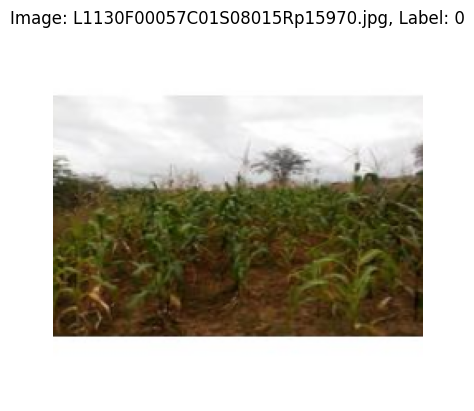

In [ ]:
# Image data preprocessing
image_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
                  rescale=1./255,
                  shear_range=0.2,
                  zoom_range=0.2,
                  horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
                      dataframe=train_df,
                      directory=os.path.join(data_path, "train_resized"),
                      x_col="filename",
                      y_col="extent",
                      target_size=image_size,
                      batch_size=batch_size,
                      class_mode="other"
)

row_index = 0

# Create a generator for a single image
single_image_generator = train_datagen.flow_from_dataframe(
                            dataframe=train_data.iloc[[row_index]],
                            directory=os.path.join(data_path, "train_resized"),
                            x_col="filename",
                            y_col="extent",
                            target_size=image_size,
                            batch_size=1,
                            class_mode="other"
)

# Get the preprocessed image and label
img, label = single_image_generator.next()

# Display the image
plt.imshow(img[0])
plt.title(f"Image: {image_filename}, Label: {label[0]}")
plt.axis('off')  # Turn off axis labels
plt.show()

In [ ]:
val_generator = val_datagen.flow_from_dataframe(
                  dataframe=val_df,
                  directory=os.path.join(data_path, "train_resized"),
                  x_col="filename",
                  y_col="extent",
                  target_size=image_size,
                  batch_size=batch_size,
                  class_mode="other"
)

Found 5222 validated image filenames.


# Build CNN Model

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential

# Build the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

print("Convonutional Base Model Summary:")
# Get summary of the model
model.summary()

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))

# model.add(Dense(11, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

print("Final Model Summary:")
# Get summary of the model
model.summary()

# Fit the model
model.fit(train_generator, epochs=5, validation_data=val_generator)



Convonutional Base Model Summary:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (Ma

# Save Model

In [ ]:
# Save the trained model
model.save('/content/drive/MyDrive/model.h5')

# If you want to load the model later
# loaded_model = load_model('/content/drive/MyDrive/model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Make Predictions

In [ ]:
import os
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Specify the path to the test directory
test_directory = '/content/drive/MyDrive/test'

In [ ]:
# Specify the target size
target_size = 224

# Create a new folder for resized test images
output_folder = '/content/drive/MyDrive/test_resized'
os.makedirs(output_folder, exist_ok=True)

# Resize and save each image in the test folder to the new folder
for image_filename in os.listdir(test_directory):
    image_path = os.path.join(test_directory, image_filename)
    output_path = os.path.join(output_folder, image_filename)

    # Check if the resized image already exists
    if os.path.exists(output_path):
        print(f"Resized image already exists: {output_path}")
    else:
        # Check if the original file exists before attempting to open it
        if os.path.exists(image_path):
            resized_image = resize_with_padding(image_path, target_size)

            # Save the resized image to the new folder
            resized_image.save(output_path)
        else:
            print(f"File not found: {image_path}")

print("Resizing and saving complete for test images.")

<ipython-input-35-906e4c45208d>:18: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = img.resize((new_width, new_height), Image.ANTIALIAS)


Resizing and saving complete for test images.


In [ ]:
test_data = pd.read_csv(os.path.join(data_path, "Test.csv"))

test_data['filename'] = test_data['filename'].str.replace('.JPG', '.jpg')

num_test_images = len(test_data['filename'])
print(f"Found {num_test_images} images in the test directory.")

output_folder = '/content/drive/MyDrive/test_resized'



# Convert file extensions to lowercase
for root, dirs, files in os.walk(output_folder):
    for file in files:
        if file.endswith(".JPG"):
            # Rename the file with lowercase extension
            os.rename(os.path.join(root, file), os.path.join(root, file.lower()))

# Create a DataFrame to store predictions
predictions_df = pd.DataFrame(columns=["ID", "extent"])


# Image data preprocessing for the test images
image_size = (224, 224)
test_datagen = ImageDataGenerator(rescale=1./255)
# test_generator = test_datagen.flow_from_directory(output_folder,
#                                                   target_size=image_size,
#                                                   batch_size=1,
#                                                   class_mode=None,
#                                                   shuffle=False)

test_generator = test_datagen.flow_from_dataframe(dataframe=test_data,
                                                  directory=output_folder,
                                                  x_col="filename",
                                                  target_size=image_size,
                                                  batch_size=1,
                                                  class_mode=None,
                                                  shuffle=False)

# Check the number of images found in the test directory
num_test_images = len(test_generator.filenames)
print(f"Found {num_test_images} images in the test directory.")

invalid_filenames = test_data[~test_data['filename'].isin(os.listdir(output_folder))]['filename']
print("Invalid Filenames:")
print(invalid_filenames)

# Only proceed if there are images in the test directory
if num_test_images > 0:
    # Make predictions on the test data
    predictions = model.predict(test_generator)

    # Add "ID" and "extent" columns to the DataFrame
    predictions_df["ID"] =  test_data['ID']
    # predictions_df["extent"] = predictions.flatten()

    predictions_df["extent"] = (predictions.flatten() * 100).round(-1)

    # Save predictions to a CSV file
    predictions_df.to_csv("/content/drive/MyDrive/predictions.csv", index=False)
    print("Predictions saved to predictions.csv.")

    # Print the predictions
    print(predictions)
else:
    print("No images found in the test directory.")

<ipython-input-69-a4764b368202>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['filename'] = test_data['filename'].str.replace('.JPG', '.jpg')


Found 8663 images in the test directory.
Found 8663 validated image filenames.
Found 8663 images in the test directory.
Invalid Filenames:
Series([], Name: filename, dtype: object)
8663/8663 [==============================] - 345s 40ms/step
Predictions saved to predictions.csv.
[[0.08560203]
 [0.10382031]
 [0.11582386]
 ...
 [0.09615682]
 [0.13962817]
 [0.1333242 ]]
